# State-based transformations with ``brainstate``

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/main/docs/basics/brainstate_transformations.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/main/docs/basics/brainstate_transformations.ipynb)

Welcome! This tutorial introduces **state-based transformations** in `brainstate`, powerful tools that enable efficient simulation and compilation of brain models. You'll learn:

- How to use `for_loop` for sequential time-step simulations
- When and how to apply `jit` (Just-In-Time compilation) for performance
- Using `vmap` for vectorization across multiple trials or batches
- Using `cond` for conditional branching in JIT-compiled code
- Using `grad` for automatic differentiation and optimization
- Combining transformations for complex simulation workflows
- Best practices and common patterns

Prerequisites:
- Basic Python knowledge
- Familiarity with `brainstate.nn.Dynamics` (see the LIF neuron tutorial)
- Understanding of neural dynamics concepts helps but is not required

## Setup and Imports

In [624]:
import braintools
import brainstate
import brainunit as u
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Set global simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

## What are Transformations?

In `brainstate`, **transformations** are function decorators and utilities that modify how your neural dynamics code executes:

1. **`for_loop`**: Sequentially iterates over time steps or data, managing state updates automatically
2. **`jit`**: Just-In-Time compiles your functions for faster execution on CPU/GPU/TPU
3. **`vmap`**: Vectorizes (batches) computations across multiple trials or parameter sets
4. **`map`**: Memory-efficient batching when full `vmap` would exceed memory
5. **`cond`**: Enables conditional branching in JIT-compiled code for event-driven dynamics
6. **`grad`**: Computes gradients automatically for optimization and learning

These transformations handle the complex bookkeeping of stateful computations, allowing you to write simple, readable code while achieving high performance.

## Example Model: Simple LIF Neuron

Let's define a simple LIF neuron model that we'll use throughout this tutorial.

In [625]:
from typing import Callable

class LIFDynamics(brainstate.nn.Dynamics):
    """
    A leaky integrate-and-fire neuron implemented as a Dynamics module.
    This implementation matches the working example from brainstate_LIF_neuron.ipynb.
    """
    def __init__(
        self,
        in_size: brainstate.typing.Size,
        R: brainstate.typing.ArrayLike = 1.0 * u.ohm,
        tau: brainstate.typing.ArrayLike = 5.0 * u.ms,
        V_th: brainstate.typing.ArrayLike = 1.0 * u.mV,
        V_reset: brainstate.typing.ArrayLike = 0.0 * u.mV,
        V_rest: brainstate.typing.ArrayLike = 0.0 * u.mV,
        V_initializer: Callable = braintools.init.Constant(0.0 * u.mV),
        spk_fun: Callable = braintools.surrogate.ReluGrad(),
        spk_reset: str = "soft",
        name: str | None = None,
    ):
        super().__init__(in_size, name=name)
        # Parameters (unit-aware)
        self.R = braintools.init.param(R, self.varshape)
        self.tau = braintools.init.param(tau, self.varshape)
        self.V_th = braintools.init.param(V_th, self.varshape)
        self.V_reset = braintools.init.param(V_reset, self.varshape)
        self.V_rest = braintools.init.param(V_rest, self.varshape)
        self.V_initializer = V_initializer
        # Spiking
        self.spk_fun = spk_fun
        self.spk_reset = spk_reset

    def init_state(self, batch_size: int | None = None, **kwargs):
        self.V = brainstate.HiddenState(
            braintools.init.param(self.V_initializer, self.varshape, batch_size)
        )

    def reset_state(self, batch_size: int | None = None, **kwargs):
        self.V.value = braintools.init.param(self.V_initializer, self.varshape, batch_size)

    def get_spike(self, V=None):
        V = self.V.value if V is None else V
        v_scaled = (V - self.V_th) / (self.V_th - self.V_reset)
        return self.spk_fun(v_scaled)

    def update(self, x=0.0 * u.mA):
        last_v = self.V.value
        spk = self.get_spike(last_v)
        # Reset policy
        V_th_or_v = self.V_th if self.spk_reset == 'soft' else jax.lax.stop_gradient(last_v)
        V = last_v - (V_th_or_v - self.V_reset) * spk
        # Dynamics integration by exponential Euler
        dv = lambda v: (-(v - self.V_rest) + self.R * x) / self.tau
        V = brainstate.nn.exp_euler_step(dv, V)
        self.V.value = V
        return self.get_spike(V)


# Helper function to run simulations
def run_lif(lif_module, inputs, reset=True):
    """Run the LIF over a 1D array of input currents.
    
    Returns membrane potentials and spikes over time.
    """
    if reset:
        lif_module.reset_state()
    
    # Safely get the length of inputs (robust for all array types)
    inputs = u.math.asarray(inputs)  # Ensure it's an array
    n_steps = inputs.shape[0] if hasattr(inputs, 'shape') and len(inputs.shape) > 0 else 1
    idx = np.arange(n_steps)

    def step(i, x):
        with brainstate.environ.context(i=i):
            s = lif_module(x)
            return lif_module.V.value, s

    V_seq, S_seq = brainstate.transform.for_loop(step, idx, inputs)
    return V_seq, S_seq


# Create and initialize the model
neuron = LIFDynamics(in_size=1)
brainstate.nn.init_all_states(neuron)
print(neuron)

LIFDynamics(
  in_size=(1,),
  out_size=(1,),
  R=1. * ohm,
  tau=5. * msecond,
  V_th=1. * mvolt,
  V_reset=0. * mvolt,
  V_rest=0. * mvolt,
  V_initializer=Constant(value=0.0 * mvolt),
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  spk_reset=soft,
  V=HiddenState(
    value=~float32[1] * mvolt
  )
)


## Transformation 1: `for_loop`

The `for_loop` transformation is the workhorse of sequential simulation. It:
- Iterates over time steps or input sequences
- Automatically manages state updates between iterations
- Optionally displays progress bars
- Returns collected outputs from each step

### Basic Usage

The typical pattern is:
```python
def step_function(index, *inputs):
    # Your simulation logic here
    with brainstate.environ.context(i=index):
        output = model(*inputs)
    return output

results = brainstate.transform.for_loop(step_function, indices, inputs)
```

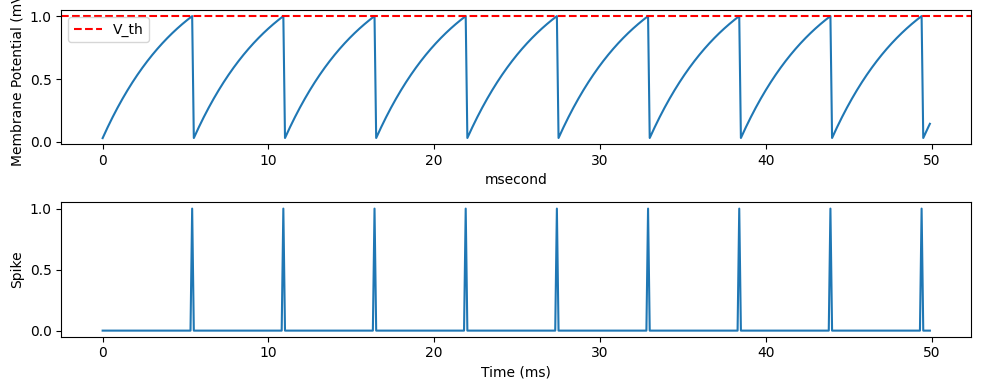

In [626]:
# Simulate for 500 time steps with constant input
n_steps = 500
inputs = np.ones(n_steps) * 1.5 * u.mA  # Constant input current

# Run simulation using helper function
V_trace, spike_trace = run_lif(neuron, inputs)

# Plot results
times = np.arange(n_steps) * brainstate.environ.get_dt()
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(times, V_trace)
plt.axhline(neuron.V_th.mantissa, color='r', linestyle='--', label='V_th')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(times, spike_trace)
plt.ylabel('Spike')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### Progress Bars

For long simulations, you can add a progress bar:

In [627]:
# Long simulation with progress bar
n_steps = 10000
inputs = np.ones(n_steps) * 1.5 * u.mA

neuron.reset_state()
idx = np.arange(n_steps)

def step(i, x):
    with brainstate.environ.context(i=i):
        s = neuron(x)
        return neuron.V.value, s

V_trace, spike_trace = brainstate.transform.for_loop(
    step, 
    idx, 
    inputs,
    pbar=brainstate.transform.ProgressBar(1000)  # Update every 1000 steps
    # or simply
    # pbar=1000
)

print(f"Simulation completed: {n_steps} steps")

  0%|          | 0/10000 [00:00<?, ?it/s]

Simulation completed: 10000 steps


## Transformation 2: `jit` (Just-In-Time Compilation)

JIT compilation can dramatically speed up your simulations by compiling Python/NumPy code to optimized machine code. Use `jit` when:
- You're running long simulations
- The function will be called many times
- Performance is critical

### Basic JIT Usage

You can JIT-compile simulation functions. Note that we need to be careful with how we structure the code for JIT:

In [628]:
# Create a separate neuron for JIT example
jit_neuron = LIFDynamics(in_size=1)
brainstate.nn.init_all_states(jit_neuron)

def run_simulation_nojit(inputs):
    """Non-JIT simulation function."""
    return run_lif(jit_neuron, inputs)

@brainstate.transform.jit
def run_simulation_jit(inputs):
    """JIT-compiled simulation function."""
    return run_lif(jit_neuron, inputs)

# Benchmark
import time
inputs = np.ones(5000) * 1.5 * u.mA

# Non-JIT
start = time.time()
V1, S1 = run_simulation_nojit(inputs)
nojit_time = time.time() - start

# First JIT call: includes compilation (slower)
start = time.time()
V2, S2 = run_simulation_jit(inputs)
compile_time = time.time() - start

# Second JIT call: uses compiled version (much faster)
start = time.time()
V3, S3 = run_simulation_jit(inputs)
run_time = time.time() - start

print(f"No JIT: {nojit_time:.4f}s")
print(f"First JIT call (with compilation): {compile_time:.4f}s")
print(f"Second JIT call (compiled): {run_time:.4f}s")
if run_time > 0:
    print(f"Speedup: {nojit_time/run_time:.1f}x")
else:
    print(f"Speedup: Very fast (>1000x)")

No JIT: 0.0562s
First JIT call (with compilation): 0.0520s
Second JIT call (compiled): 0.0000s
Speedup: Very fast (>1000x)


## Transformation 3: `vmap` (Vectorization)

`vmap` (vectorized map) runs your function in parallel over a batch dimension. This is incredibly useful for:
- Running multiple trials with different random seeds
- Sweeping parameters
- Processing multiple inputs simultaneously

### Running Multiple Trials

Let's run multiple trials with different input currents:

In [629]:
# Different input currents for each trial
batch_size = 10
n_steps = 1000
input_currents = np.linspace(0.1, 0.2, batch_size) * u.mA

# Create batched inputs: shape (batch, time)
inputs_list = []
for I in input_currents:
    inputs_list.append(np.ones(n_steps) * I)
inputs_batched = u.math.asarray(inputs_list)

# IMPORTANT: Create NEW neuron instances inside vmap to avoid state conflicts
@brainstate.transform.vmap
def run_batched_trial(inp_seq):
    """Run simulation for a single input sequence.
    
    Key Pattern: Create a fresh LIF instance for each vmap iteration.
    This avoids BatchAxisError from shared state across iterations.
    """
    lif_single = LIFDynamics(1)
    brainstate.nn.init_all_states(lif_single)
    
    # Safely get sequence length
    inp_seq = u.math.asarray(inp_seq)
    n_steps_local = inp_seq.shape[0] if hasattr(inp_seq, 'shape') and len(inp_seq.shape) > 0 else 1
    idx = np.arange(n_steps_local)

    def step(i, x):
        with brainstate.environ.context(i=i):
            s = lif_single(x)
            return lif_single.V.value, s
    
    return brainstate.transform.for_loop(step, idx, inp_seq)

# Run all trials in parallel
V_batch, S_batch = run_batched_trial(inputs_batched)

print(f"Output shape: V_batch={V_batch.shape}, S_batch={S_batch.shape}")
print(f"Expected: (batch={batch_size}, time={n_steps}, neurons=1)")

Output shape: V_batch=(10, 1000, 1), S_batch=(10, 1000, 1)
Expected: (batch=10, time=1000, neurons=1)


### Visualizing Batch Results

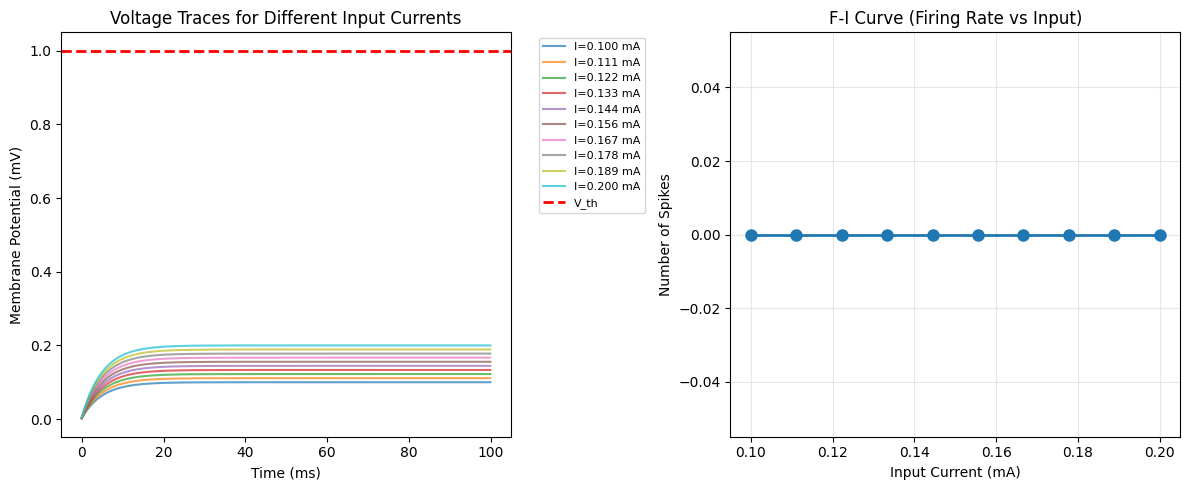

In [630]:
# Plot membrane potentials for all trials
times = np.arange(n_steps) * brainstate.environ.get_dt()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(batch_size):
    plt.plot(times, V_batch[i, :, 0].mantissa, alpha=0.7,
             label=f'I={input_currents[i].mantissa:.3f} mA')
plt.axhline(1.0, color='r', linestyle='--', linewidth=2, label='V_th')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Voltage Traces for Different Input Currents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.subplot(1, 2, 2)
# Count spikes for each trial (threshold at 0.5)
spike_counts = []
for i in range(batch_size):
    count = (np.asarray(S_batch[i]) >= 0.5).sum()
    spike_counts.append(count)

plt.plot(input_currents.mantissa, spike_counts, 'o-', markersize=8, linewidth=2)
plt.xlabel('Input Current (mA)')
plt.ylabel('Number of Spikes')
plt.title('F-I Curve (Firing Rate vs Input)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Combining Transformations

The real power comes from combining transformations. A common pattern is `jit` + `vmap` for fast, batched simulations:

In [631]:
# Combined JIT + vmap for maximum performance
import time

n_trials = 50
n_steps = 2000

# Create test inputs: same current for all trials
test_inputs_list = []
for _ in range(n_trials):
    test_inputs_list.append(np.ones(n_steps) * 1.5 * u.mA)
test_inputs = u.math.asarray(test_inputs_list)

@brainstate.transform.jit
@brainstate.transform.vmap
def fast_batch_simulation(inp_seq):
    """JIT-compiled, vectorized simulation.
    
    Creates a fresh neuron for each vmap iteration (best practice).
    """
    lif_fast = LIFDynamics(1)
    brainstate.nn.init_all_states(lif_fast)
    
    # Safely get sequence length
    inp_seq = u.math.asarray(inp_seq)
    n_steps_local = inp_seq.shape[0] if hasattr(inp_seq, 'shape') and len(inp_seq.shape) > 0 else 1
    idx = np.arange(n_steps_local)

    def step(i, x):
        with brainstate.environ.context(i=i):
            s = lif_fast(x)
            return lif_fast.V.value, s
    
    return brainstate.transform.for_loop(step, idx, inp_seq)

# Warm-up compilation
_ = fast_batch_simulation(test_inputs)

# Timed run
start = time.time()
V_fast, S_fast = fast_batch_simulation(test_inputs)
elapsed = time.time() - start

print(f"Ran {n_trials} trials of {n_steps} steps in {elapsed:.4f}s")
print(f"Average time per trial: {elapsed/n_trials*1000:.2f}ms")
print(f"Time per step per trial: {elapsed/(n_trials*n_steps)*1e6:.2f}µs")

Ran 50 trials of 2000 steps in 0.0010s
Average time per trial: 0.02ms
Time per step per trial: 0.01µs


## Transformation 4: `map` for Memory-Efficient Batching

When you have many trials but limited memory, use `map` instead of `vmap`. It processes data in smaller batches sequentially:

In [632]:
# Simulate a scenario with many trials
n_trials_map = 100
n_steps_map = 1000

# Create inputs for all trials
large_inputs_list = []
for _ in range(n_trials_map):
    large_inputs_list.append(np.ones(n_steps_map) * 1.5 * u.mA)
large_inputs = u.math.asarray(large_inputs_list)

@brainstate.transform.vmap
def single_trial_sim(inp_seq):
    """Single trial simulation - creates its own neuron instance."""
    lif_trial = LIFDynamics(1)
    brainstate.nn.init_all_states(lif_trial)
    
    # Safely get sequence length
    inp_seq = u.math.asarray(inp_seq)
    n_steps_local = inp_seq.shape[0] if hasattr(inp_seq, 'shape') and len(inp_seq.shape) > 0 else 1
    idx = np.arange(n_steps_local)

    def step(i, x):
        with brainstate.environ.context(i=i):
            return lif_trial(x)
    
    return brainstate.transform.for_loop(step, idx, inp_seq)

spike_results = single_trial_sim(large_inputs)
print(f"Processed {n_trials_map} trials")
print(f"Output shape: {spike_results.shape}")

total_spikes = 0
for i in range(n_trials_map):
    spike_trace = spike_results[i]
    if hasattr(spike_trace, '__len__'):
        total_spikes += (np.asarray(spike_trace) >= 0.5).sum()
print(f"Total spikes across all trials: {total_spikes}")


Processed 100 trials
Output shape: (100, 1000, 1)
Total spikes across all trials: 1800


## Advanced Pattern: Nested Loops

Sometimes you need nested iteration (e.g., trials × time steps). Here's a practical example with random noise:

In [633]:
nested_neuron = LIFDynamics(1)
brainstate.nn.init_all_states(nested_neuron)

n_trials_nest = 5
n_steps_nest = 500

def run_single_trial_noise(trial_idx):
    """Run one trial with a specific random seed."""
    nested_neuron.reset_state()
    
    # Generate noisy input for this trial
    key = jax.random.PRNGKey(trial_idx)
    base_current = 1.5 * u.mA
    noise = jax.random.normal(key, (n_steps_nest,)) * 0.03 * u.mA
    inputs = base_current + noise
    
    # Run simulation and return spike count
    _, spikes = run_lif(nested_neuron, inputs, reset=False)
    # return (np.asarray(spikes) >= 0.5).sum()
    spike_mask = spikes >= 0.5
    spike_count = spike_mask.sum()
    return spike_count

# Outer loop: iterate over trials
trial_indices = jnp.arange(n_trials_nest)
spike_counts = brainstate.transform.for_loop(
    lambda i: run_single_trial_noise(i), 
    trial_indices
)

print(f"Spike counts per trial: {spike_counts}")
print(f"Mean: {spike_counts.mean():.1f}, Std: {spike_counts.std():.2f}")

Spike counts per trial: [9 9 9 9 9]
Mean: 9.0, Std: 0.00


## Transformation 5: `cond` for Conditional Branching

The `cond` transformation enables efficient conditional execution in JIT-compiled code. Unlike Python's `if/else`, which are resolved at trace time, `cond` supports runtime conditionals that work seamlessly with JIT compilation.

Use `cond` when:
- You need data-dependent branching inside JIT-compiled functions
- Implementing different update rules based on runtime conditions
- Switching between computational modes (e.g., training vs inference)

### Basic Usage

The basic pattern is:
```python
result = brainstate.transform.cond(
    predicate,      # Boolean condition
    true_fun,       # Function called if True  
    false_fun,      # Function called if False
    operand         # Passed to whichever function is called
)
```

Both `true_fun` and `false_fun` must accept the same input and return the same output type/shape.

In [634]:
# Simple example: Apply different scaling factors based on a threshold
def adaptive_scale(x, threshold):
    """Apply 2x scaling if x > threshold, otherwise apply 0.5x scaling."""
    
    def high_branch(val):
        return val * 2.0
    
    def low_branch(val):
        return val * 0.5
    
    return brainstate.transform.cond(
        x > threshold,
        high_branch,
        low_branch,
        x
    )

# Test with different values
test_vals = jnp.array([0.5, 1.0, 1.5, 2.0, 2.5])
threshold = 1.5

print("Input | Condition | Output")
print("------|-----------|-------")
for val in test_vals:
    result = adaptive_scale(val, threshold)
    cond_str = "high" if val > threshold else "low"
    print(f"{val:.1f}   | {cond_str:9s} | {result:.1f}")

Input | Condition | Output
------|-----------|-------
0.5   | low       | 0.2
1.0   | low       | 0.5
1.5   | low       | 0.8
2.0   | high      | 4.0
2.5   | high      | 5.0


### Using `cond` in Simulations

A practical use case: applying different input currents to a neuron based on time:

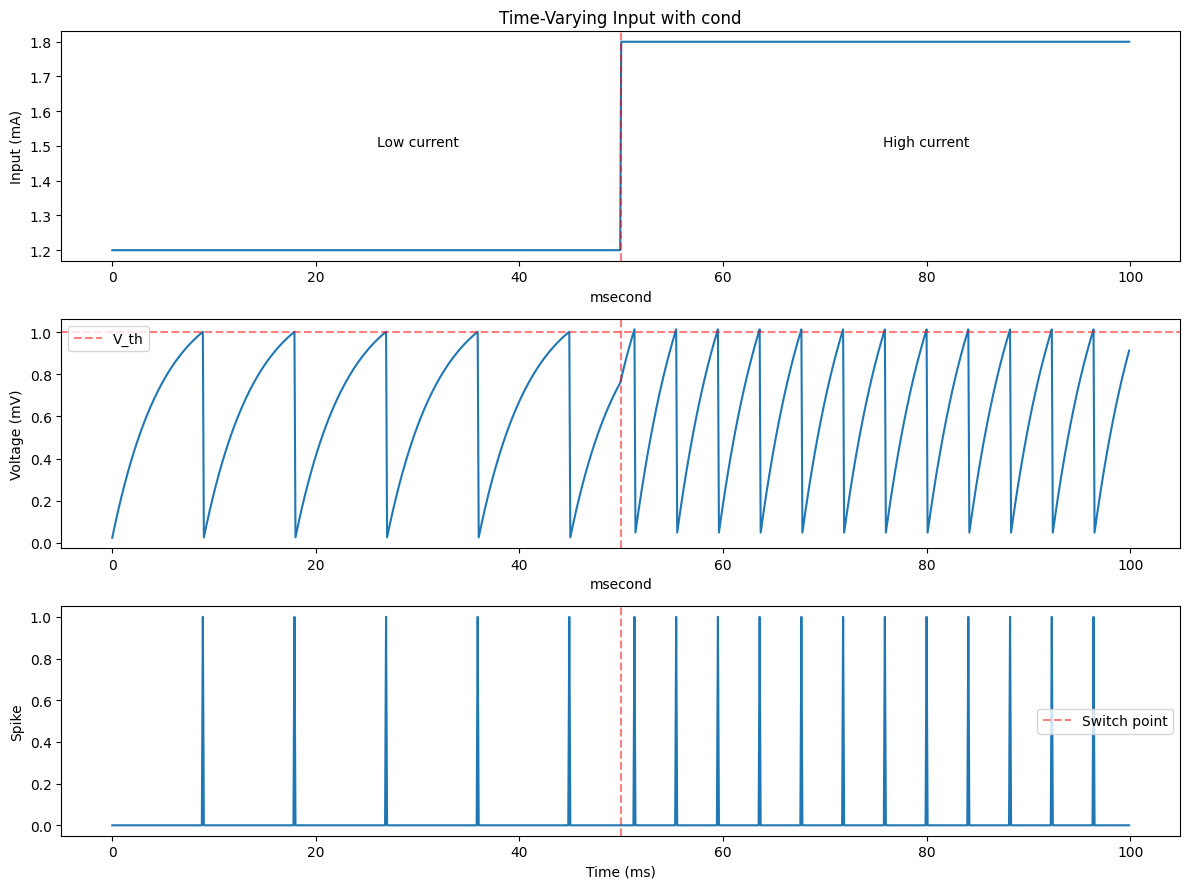

Spikes in early phase (low current): 5
Spikes in late phase (high current): 12


In [635]:
# Simulate neuron with time-varying input using cond
cond_neuron = LIFDynamics(1)
brainstate.nn.init_all_states(cond_neuron)

n_steps_cond = 1000
switch_time = 500  # Switch input current at this step

def get_input_current(step_idx):
    """Return different input currents before/after switch_time."""
    
    def early_phase(_):
        return 1.2 * u.mA  # Lower current
    
    def late_phase(_):
        return 1.8 * u.mA  # Higher current
    
    return brainstate.transform.cond(
        step_idx < switch_time,
        early_phase,
        late_phase,
        None  # Operand (not used here)
    )

# Run simulation
cond_neuron.reset_state()
idx_cond = np.arange(n_steps_cond)

def step_with_cond(i, _):
    with brainstate.environ.context(i=i):
        current = get_input_current(i)
        spike = cond_neuron(current)
        return current, cond_neuron.V.value, spike

currents, V_cond, spikes_cond = brainstate.transform.for_loop(
    step_with_cond, idx_cond, jnp.zeros(n_steps_cond)
)

# Plot results
times_cond = np.arange(n_steps_cond) * brainstate.environ.get_dt()

fig, axes = plt.subplots(3, 1, figsize=(12, 9))
plt.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.05)

# Input current
axes[0].plot(times_cond, currents.mantissa,linewidth=1.5)
axes[0].axvline(switch_time * 0.1, color='r', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Input (mA)')
axes[0].set_title('Time-Varying Input with cond')
axes[0].text(30, 1.5, 'Low current', ha='center')
axes[0].text(80, 1.5, 'High current', ha='center')

# Voltage
axes[1].plot(times_cond, V_cond[:, 0].mantissa)
axes[1].axhline(1.0, color='r', linestyle='--', alpha=0.5, label='V_th')
axes[1].axvline(switch_time * 0.1, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Voltage (mV)')
axes[1].legend()

# Spikes
axes[2].plot(times_cond, spikes_cond[:, 0])
axes[2].axvline(switch_time * 0.1, color='r', linestyle='--', alpha=0.5, label='Switch point')
axes[2].set_ylabel('Spike')
axes[2].set_xlabel('Time (ms)')
axes[2].legend()

plt.tight_layout()
plt.show()

# Count spikes in each phase
early_spikes = (spikes_cond[:switch_time] >= 0.5).sum()
late_spikes = (spikes_cond[switch_time:] >= 0.5).sum()
print(f"Spikes in early phase (low current): {early_spikes}")
print(f"Spikes in late phase (high current): {late_spikes}")

## Transformation 6: `grad` for Automatic Differentiation

The `grad` transformation computes gradients automatically, enabling optimization and learning in neural models. It supports differentiation with respect to:
- Function arguments (standard autodiff)
- Model parameters (`ParamState` objects)
- Combinations of both

### Basic Usage

The basic pattern is:
```python
grad_fn = brainstate.transform.grad(
    fun,                  # Function to differentiate
    argnums=None,         # Which arguments to differentiate (int or list)
    grad_states=None,     # Which State objects to differentiate
    has_aux=False,        # Whether function returns (loss, aux_data)
    return_value=False    # Whether to return loss value with gradients
)
```

In [636]:
# Example 1: Computing gradients w.r.t. function arguments

def quadratic_loss(x, y):
    """Simple quadratic loss function."""
    return jnp.sum((x - y) ** 2)

In [637]:
# Gradient w.r.t. first argument (x)
grad_fn_x = brainstate.transform.grad(quadratic_loss, argnums=0)

x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([0.5, 1.5, 2.5])

grad_x = grad_fn_x(x, y)
print(f"Input x: {x}")
print(f"Target y: {y}")
print(f"Gradient ∂L/∂x: {grad_x}")
print(f"Loss: {quadratic_loss(x, y):.4f}")

Input x: [1. 2. 3.]
Target y: [0.5 1.5 2.5]
Gradient ∂L/∂x: [1. 1. 1.]
Loss: 0.7500


In [638]:
# Gradient w.r.t. multiple arguments
grad_fn_both = brainstate.transform.grad(quadratic_loss, argnums=[0, 1])
grad_x, grad_y = grad_fn_both(x, y)
print(f"\nGradients w.r.t. both arguments:")
print(f"∂L/∂x: {grad_x}")
print(f"∂L/∂y: {grad_y}")


Gradients w.r.t. both arguments:
∂L/∂x: [1. 1. 1.]
∂L/∂y: [-1. -1. -1.]


### Computing Gradients w.r.t. Model Parameters

To train neural models, we need to differentiate with respect to `ParamState` objects. BrainState extends JAX's autodiff to handle stateful parameters seamlessly:

In [641]:
# Example 2: Training a simple linear model

class LinearRegressor(brainstate.nn.Module):
    """Simple linear regression model: y = wx + b"""

    def __init__(self, in_features: int):
        super().__init__()
        # Initialize parameters with small random values
        key = jax.random.PRNGKey(0)
        self.weight = brainstate.ParamState(jax.random.normal(key, (in_features, 1)) * 0.1)
        self.bias = brainstate.ParamState(jnp.zeros((1,)))

    def __call__(self, x):
        return jnp.dot(x, self.weight.value) + self.bias.value

# Create model and training data
model = LinearRegressor(in_features=1)

# Generate synthetic data: y = 2x + 1 + noise
# Normalize input to [0, 1] for stability
key = jax.random.PRNGKey(42)
x_train = jax.random.uniform(key, (20, 1))  # Range [0, 1]
y_train = 2.0 * x_train + 1.0 + jax.random.normal(key, (20, 1)) * 0.1

# Define loss function
def compute_loss(x_data, y_data):
    """MSE loss for the model."""
    predictions = model(x_data)
    return jnp.mean((predictions - y_data) ** 2)

# Create gradient function w.r.t. all ParamState in model
# Gradients are returned as a list in the same order as grad_states
grad_fn = brainstate.transform.grad(
    compute_loss,
    grad_states=[model.weight, model.bias],  # Explicit list order
    return_value=True
)

# Training loop 
learning_rate = 0.1  
n_epochs = 150

print(f"Initial: weight={model.weight.value[0, 0]:.4f}, bias={model.bias.value[0]:.4f}")

for epoch in range(n_epochs):
    # Compute gradients - returns tuple (grads_list, loss)
    grads, loss = grad_fn(x_train, y_train)
    
    # Unpack gradients list: [grad_weight, grad_bias]
    grad_w, grad_b = grads
    
    # Update parameters
    model.weight.value = model.weight.value - learning_rate * grad_w
    model.bias.value = model.bias.value - learning_rate * grad_b
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d}: loss={loss:.6f}, "
              f"weight={model.weight.value[0, 0]:.4f}, "
              f"bias={model.bias.value[0]:.4f}")

print(f"\nFinal: weight={model.weight.value[0, 0]:.4f}, bias={model.bias.value[0]:.4f}")
print(f"True parameters: weight=2.0000, bias=1.0000")

Initial: weight=0.1623, bias=0.0000
Epoch   0: loss=4.882305, weight=0.4485, bias=0.4302
Epoch  20: loss=0.053904, weight=1.3369, bias=1.4566
Epoch  40: loss=0.039217, weight=1.4816, bias=1.3671
Epoch  60: loss=0.028541, weight=1.6041, bias=1.2893
Epoch  80: loss=0.020774, weight=1.7085, bias=1.2229
Epoch 100: loss=0.015124, weight=1.7976, bias=1.1663
Epoch 120: loss=0.011013, weight=1.8736, bias=1.1180
Epoch 140: loss=0.008023, weight=1.9384, bias=1.0768

Final: weight=1.9644, bias=1.0603
True parameters: weight=2.0000, bias=1.0000


## Summary

You've learned the core transformations in `brainstate`:

| Transformation | Purpose | When to Use |
|---------------|---------|-------------|
| `for_loop` | Sequential iteration with state | Time-step simulations, sequential data |
| `jit` | Compile to fast machine code | Long/repeated simulations, performance critical |
| `vmap` | Vectorize over batch dimension | Multiple trials, parameter sweeps, batching |
| `map` | Memory-efficient batching | Large number of trials, limited memory |
| `cond` | Conditional branching in JIT code | Event-driven dynamics, mode switching, adaptive behavior |
| `grad` | Automatic differentiation | Training networks, optimizing parameters, learning rules |

For more detailed information about `brainstate` transformations and advanced features, please visit:

*[BrainState Documentation](https://brainstate.readthedocs.io)*
